# Evaluating the Retriever & End-to-End System
> A review of Information Retrieval and the role it plays in a QA system

- title: "Evaluating the Retriever & End-to-End System"
- toc: true 
- badges: true
- comments: true
- hide: true
- permalink: /hidden/
- search_exclude: false
- use_math: true
- categories:

In our last post, [Evaluating QA: Metrics, Predictions, and the Null Response](https://qa.fastforwardlabs.com/no%20answer/null%20threshold/bert/distilbert/exact%20match/f1/robust%20predictions/2020/06/09/Evaluating_BERT_on_SQuAD.html), we took a deep dive look at how to asses the quality of a BERT-like Reader for Question Answering (QA) using the Hugging Face framework. In this post, we'll focus on the former component of a modern Information Retrieval-based (IR) QA system - the Retriever. Specifically, we'll introduce Elasticsearch as a powerful and efficient IR tool that can be used to scour through large corpora and retrieve relevant documents. We'll explain how to implement and evaluate a Retriever in the context of Question Answering and demonstrate it's impact on an IR QA system.

### Prerequisites
* a basic understanding of Information Retrieval & Search
* a basic understanding of IR based QA systems (see previous posts)
* a basic understanding of Transformers and PyTorch
* a basic understanding of the SQuAD2.0 dataset

# Retrieving the right document is important

![](https://github.com/fastforwardlabs/ff14_blog/blob/master/_notebooks/my_icons/michael_scott_quote.jpg?raw=1)


We believe what Michael Scott really meant to say is:

> "***You miss 100% of the questions if the answer doesn't appear in the input context***"

As we've discussed throughout this series, many modern QA systems take a two-staged approach to answering questions. In the first stage, a document retriever selects *N* potentially relevant documents from a given corpus. Subsequently, a machine comprehension model processes each of the *N* documents to determine an answer to the input question. Because of recent advances in NLP and deep learning (i.e. flashy Transformers), the machine comprehension component has typically been the main focus of evaluation and performance enhancement.  Retrievers have recieved limited attention in the context of QA despite their obvious importance: stage two of an IR QA system is bounded by the performance of stage one. Let's get more specific.

We [recently explained methods](https://qa.fastforwardlabs.com/no%20answer/null%20threshold/bert/distilbert/exact%20match/f1/robust%20predictions/2020/06/09/Evaluating_BERT_on_SQuAD.html) that enable BERT-like models to produce robust answers given a question and context passage by selectively processing predictions and by refraining from answering certain questions at all. While the ability to properly comprehend a passage and produce a correct answer is a critical feature of any QA tool, the success of the overall system is highly dependent on first providing a correct passage to read through. Without being fed a context passage that actually contains the ground-truth answer, the overall system's performance is limited to how well it can predict no-answer questions. To demonstrate, we'll revisit an example from our [second blog post](https://qa.fastforwardlabs.com/pytorch/hugging%20face/wikipedia/bert/transformers/2020/05/19/Getting_Started_with_QA.html) where three questions were asked of the Wikipedia search engine based QA system:

```
**Example 1: Incorrect**
Question: When was Barack Obama born?
Top wiki result: <WikipediaPage 'Barack Obama Sr.'>
Answer: 18 June 1936 / February 2 , 1961 / 

**Example 2: Correct**
Question: Why is the sky blue?
Top wiki result: <WikipediaPage 'Diffuse sky radiation'>
Answer: Rayleigh scattering / 

**Example 3: Correct**
Question: How many sides does a pentagon have?
Top wiki result: <WikipediaPage 'The Pentagon'>
Answer: five / 
```

In Example 1, the Reader had no chance of producing the correct answer because of its outright absence from the context served up by the Retriever. Namely, the Retriever erroneously provided a page about Barack Obama Sr. instead of his son, the former US President. In this case, the only way the Reader could have possibly produced the correct answer was if the correct answer was actually not to answer at all. On the flip side, in Example 3, the Retriever did not identify the globally "correct" document - it returned an article about "The Pentagon" instead of a page about geometry - but nonetheless, it provided enough context for the Reader to succeed.

These quick examples illustrate why an effective Retriever is crucial for an end-to-end QA system. Now let's take a deeper look at a classic tool used for information retrieval - Elasticsearch.

# Elasticsearch as an IR Tool

![](https://github.com/fastforwardlabs/ff14_blog/blob/master/_notebooks/my_icons/elasticsearch-logo.png?raw=1)

Modern QA systems employ a variety of techniques for the task of information retrieval ranging from traditional sparse vector word matching (ex. Elasticsearch) to [novel approaches](https://arxiv.org/pdf/2004.04906.pdf) using dense representations of encoded passages combined with [efficient search capabilities](https://github.com/facebookresearch/faiss). Despite the flurry of contemporary research efforts in this area, the traditional sparse vector approach performs very well overall and has only recently been overtaken by embedding-based systems for end-to-end QA retrieval tasks. For that reason, we'll explore Elasticsearch as an easy to use framework for document retrieval. So, what exactly is Elasticsearch?

Elasticsearch is a powerful open-source search and analytics engine built on the [Apache Lucene](https://lucene.apache.org/) library that is capable of handling all types of data including textual, numerical, geospatial, structrured, and unstructured. It is built to scale with a robust set of features, rich ecosystem, and diverse list of client libraries making it easy to integrate and use. In the context of information retrieval for automated question answering, we are keenly interested in the features surrounding full-text search. Elasticsearch provides a convenient way to index documents so they can quickly be queried for nearest neighbor search using a TF-IDF based similarity metric. Specifically, it uses [BM25](https://opensourceconnections.com/blog/2015/10/16/bm25-the-next-generation-of-lucene-relevation/) term weighting to represent question and context passages as high-dimensional, sparse vectors that are efficiently searched in an inverted index. For more information on how an inverted index works under the hood, we recommend this quick and concise [blog post](https://codingexplained.com/coding/elasticsearch/understanding-the-inverted-index-in-elasticsearch).

## Using Elasticsearch with SQuAD2.0

With this basic understanding of how Elasticsearch works, let's dive in and build our own Document Retrieval system by indexing a set of Wikipedia article paragraphs that support questions and answers from the SQuAD2.0 dataset. Before we get started, we'll need to download and prepare data from SQuAD2.0.

 **Download and Prepare SQUAD2.0**

In [1]:
# collapse-hide

# Download the SQuAD2.0 train & dev sets
!wget -P data/squad/ https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
!wget -P data/squad/ https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
    
import json

A common practice in IR for QA is to segment large articles into smaller passages before indexing for two main reasons:

1. **Transformer based Readers are slow** - providing an entire Wikipedia article to BERT for processing can take 5 - 30 seconds even with a decent GPU! 
2. **Smaller passages reduce noise** - by identifying a more concise context passage for BERT to read through, we reduce the chance of BERT getting lost.

Of course the chunking method proposed here doesn't come without a cost. Larger documents contain more information to retrieve on. By reducing passage size, we are potentially trading off system recall for speed - though there are techniques to alleviate this as we will disucss later in the post.

With our chunking approach, each article paragraph will be prepended with the article title and collectively serve as a corpus of documents for which our Elasticsearch Retriever will search over. In practice, open-domain QA systems sit atop massive collections of documents (think all of Wikipedia) to provide a breadth of information to answer general-knowledge questions from. For the purposes of demonstrating Elasticsearch functionality, we will limit our corpus to only the Wikipedia articles supporting SQuAD2.0 questions.

The following `parse_qa_records` function will extract question/answer examples, as well as paragraph content from the SQuAD2.0 data set.

In [2]:
# collapse-hide

def parse_qa_records(data):
    '''
    Loop through SQuAD2.0 dataset and parse out question/answer examples and unique article paragraphs
    
    Returns:
        qa_records (list) - Question/answer examples as list of dictionaries
        wiki_articles (list) - Unique Wikipedia titles and article paragraphs recreated from SQuAD data
    
    '''
    num_with_ans = 0
    num_without_ans = 0
    qa_records = []
    wiki_articles = {}
    
    for article in data:
        
        for i, paragraph in enumerate(article['paragraphs']):
            
            wiki_articles[article['title']+f'_{i}'] = article['title'] + ' ' + paragraph['context']
            
            for questions in paragraph['qas']:
                
                qa_record = {}
                qa_record['example_id'] = questions['id']
                qa_record['document_title'] = article['title']
                qa_record['question_text'] = questions['question']
                
                try: 
                    qa_record['short_answer'] = questions['answers'][0]['text']
                    num_with_ans += 1
                except:
                    qa_record['short_answer'] = ""
                    num_without_ans += 1
                    
                qa_records.append(qa_record)
        
        
    wiki_articles = [{'document_title':title, 'document_text': text}\
                         for title, text in wiki_articles.items()]
                
    print(f'Data contains {num_with_ans} question/answer pairs with a short answer, and {num_without_ans} without.'+
          f'\nThere are {len(wiki_articles)} unique wikipedia article paragraphs.')
                
    return qa_records, wiki_articles

In [3]:
# load and parse data
train_file = "data/squad/train-v2.0.json"
dev_file = "data/squad/dev-v2.0.json"

train = json.load(open(train_file, 'rb'))
dev = json.load(open(dev_file, 'rb'))

qa_records, wiki_articles = parse_qa_records(train['data'])
qa_records_dev, wiki_articles_dev = parse_qa_records(dev['data'])

Data contains 86821 question/answer pairs with a short answer, and 43498 without.
There are 19035 unique wikipedia article paragraphs.
Data contains 5928 question/answer pairs with a short answer, and 5945 without.
There are 1204 unique wikipedia article paragraphs.


In [ ]:
# Parsed record example
qa_records[10]

{'example_id': '56d43c5f2ccc5a1400d830ab',
 'document_title': 'Beyoncé',
 'question_text': 'What was the first album Beyoncé released as a solo artist?',
 'short_answer': 'Dangerously in Love'}

In [ ]:
# Parsed wiki paragraph example
print(wiki_articles[10])

{'document_title': 'Beyoncé_10', 'document_text': 'Beyoncé Beyoncé\'s first solo recording was a feature on Jay Z\'s "\'03 Bonnie & Clyde" that was released in October 2002, peaking at number four on the U.S. Billboard Hot 100 chart. Her first solo album Dangerously in Love was released on June 24, 2003, after Michelle Williams and Kelly Rowland had released their solo efforts. The album sold 317,000 copies in its first week, debuted atop the Billboard 200, and has since sold 11 million copies worldwide. The album\'s lead single, "Crazy in Love", featuring Jay Z, became Beyoncé\'s first number-one single as a solo artist in the US. The single "Baby Boy" also reached number one, and singles, "Me, Myself and I" and "Naughty Girl", both reached the top-five. The album earned Beyoncé a then record-tying five awards at the 46th Annual Grammy Awards; Best Contemporary R&B Album, Best Female R&B Vocal Performance for "Dangerously in Love 2", Best R&B Song and Best Rap/Sung Collaboration for "

**Download Elasticsearch**

With our data ready to go, let's download, install, and configure Elasticsearch. We recommend running this notebook in Colab and executing the following code snippet for automatic setup. However, if you prefer to run locally, follow the instructions [here](https://www.elastic.co/downloads/elasticsearch). After completing the setup, we will have an Elasticsearch service running locally.


In [4]:
# collapse-hide

# If using Colab - Start Elasticsearch from source
! wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.6.2-linux-x86_64.tar.gz -q
! tar -xzf elasticsearch-7.6.2-linux-x86_64.tar.gz
! chown -R daemon:daemon elasticsearch-7.6.2

import os
from subprocess import Popen, PIPE, STDOUT
es_server = Popen(['elasticsearch-7.6.2/bin/elasticsearch'],
                   stdout=PIPE, stderr=STDOUT,
                   preexec_fn=lambda: os.setuid(1)  # as daemon
                  )
# wait until ES has started
! sleep 30

**Load Data into Elasticsearch**

We'll use the [official low-level Python client library](https://elasticsearch-py.readthedocs.io/en/master/) for interacting with Elasticsearch.

In [2]:
# collapse-hide
!pip install elasticsearch
!pip install tqdm

By default, Elasticsearch is launched locally on port 9200. We first need to instantiate an Elasticsearch client object and connect to the service.

In [6]:
from elasticsearch import Elasticsearch

config = {'host':'localhost', 'port':9200}
es = Elasticsearch([config])

# test connection
es.ping()

True

Before we go further, let's introduce a few concepts that are specific to Elasticsearch and the process of indexing data. In Elasticsearch, an ***index*** is a collection of documents that have common characteristics (similar to a database schema in an RDBMS). ***Documents*** are JSON objects having their own set of key-value pairs consisting of various data types (similar to rows/fields in RDBMS). When we add a document into an index, the value for the document's text fields go through an analysis process prior to being indexed. This means that when executing a search query against an existing index, we are actually searching against the post-processed representation that is stored in the inverted index, not the raw input document itself.

![Elasticsearch Index Process](https://github.com/fastforwardlabs/ff14_blog/blob/master/_notebooks/my_icons/elastic_index_process.png?raw=1)
[Image Credit](https://codingexplained.com/coding/elasticsearch/understanding-analysis-in-elasticsearch-analyzers#:~:text=A%20Closer%20Look%20at%20Analyzers,documents%20when%20they%20are%20indexed.&text=An%20analyzer%20consists%20of%20three,them%20changing%20the%20input%20stream.)

The anaysis process is a customizable pipeline carried out by a dedicated ***Analyzer***. Elasticsearch analyzers are composed of three sequential steps that form a processing pipeline: *character filters, a tokenizer, and token filters.* Each of these components modify the input stream of text according to some configurable settings. 
- **Character Filters:** have the ability to add, remove, or replace specific items in the text field. A common application is to strip `html` markup from the raw input. 
- **Tokenizer:** the character-filtered text is passed to a tokenizer which breaks up the input string into individual tokens with a provided strategy. The default (`standard`) tokenizer splits tokens on whitespace, and most symbols (like commas, periods, semicolons, etc.)
- **Token Filters:** the token stream is passed to a token filter which adds, removes, or modifies tokens. Typical token filters include converting all text to `lowercase`, and removing `stop` words. 

Elasticsearch comes with several built-in Analyzers that satisfy common use cases and defaults to the `Standard Analyzer`. The Standard Analyzer doesn't contain any character filters, uses a `standard` tokenizer, and applies a `lowercase` token filter. Let's take a look at [this example](https://medium.com/elasticsearch/introduction-to-analysis-and-analyzers-in-elasticsearch-4cf24d49ddab) sentence as its passed through this pipeline:

> "I'm in the mood for drinking semi-dry red wine!"

![Elasticsearch Analyzer Pipeline](https://github.com/fastforwardlabs/ff14_blog/blob/master/_notebooks/my_icons/elasticsearch_standard_analyzer.png?raw=1)
[Image Credit](https://codingexplained.com/coding/elasticsearch/understanding-analysis-in-elasticsearch-analyzers#:~:text=A%20Closer%20Look%20at%20Analyzers,documents%20when%20they%20are%20indexed.&text=An%20analyzer%20consists%20of%20three,them%20changing%20the%20input%20stream.)

Crafting analyzers to your use case requires domain knowledge of the problem and dataset at hand, and doing so properly is key to optimizing relevance scoring for your search application. We found [this blog series](https://medium.com/elasticsearch/introduction-to-analysis-and-analyzers-in-elasticsearch-4cf24d49ddab) very useful in explaining the importance of analysis in Elasticsearch.

**_Create an Index_**


Let's create a new index and add our Wikipedia articles to it. To do so, we provide a name and optionally some index configurations. Here we are specifying a set of `mappings` that indicate our anticipated index schema, data types, and how the text fields should be processed. If no `body` is passed, Elasticsearch will automatically infer fields and data types from incoming documents, as well as apply the `Standard Analyzer` to any text fields.

In [7]:
index_config = {
    "settings": {
        "analysis": {
            "analyzer": {
                "standard_analyzer": {
                    "type": "standard"
                }
            }
        }
    },
    "mappings": {
        "dynamic": "strict", 
        "properties": {
            "document_title": {"type": "text", "analyzer": "standard_analyzer"},
            "document_text": {"type": "text", "analyzer": "standard_analyzer"}
            }
        }
    }

index_name = 'squad-standard-index'
es.indices.create(index=index_name, body=index_config, ignore=400)

{'acknowledged': True,
 'index': 'squad-standard-index',
 'shards_acknowledged': True}

**_Populate the Index_**

We can then loop through our list of Wikipedia titles & articles and add them to our newly created Elasticsearch index.

In [8]:
# collapse-hide
from tqdm.notebook import tqdm

def populate_index(es_obj, index_name, evidence_corpus):
    '''
    Loads records into an existing Elasticsearch index

    Args:
        es_obj (elasticsearch.client.Elasticsearch) - Elasticsearch client object
        index_name (str) - Name of index
        evidence_corpus (list) - List of dicts containing data records

    '''

    for i, rec in enumerate(tqdm(evidence_corpus)):
    
        try:
            index_status = es_obj.index(index=index_name, id=i, body=rec)
        except:
            print(f'Unable to load document {i}.')
            
    n_records = es_obj.count(index=index_name)['count']
    print(f'Succesfully loaded {n_records} into {index_name}')


    return

In [9]:
all_wiki_articles = wiki_articles + wiki_articles_dev

populate_index(es_obj=es, index_name='squad-standard-index', evidence_corpus=all_wiki_articles)


Succesfully loaded 20239 into squad-standard-index


**_Search the Index_**

Wahoo! We now have some documents loaded into into an index. Elasticsearch provides a rich [query language](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl.html) that supports a diverse range of query types. For this example, we'll use the standard query for performing full-text search called a `match` query. By default, Elasticsearch sorts and returns a JSON reponse of search results based on a computed [relevance score](https://qbox.io/blog/practical-guide-elasticsearch-scoring-relevancy#:~:text=Together%2C%20these%20combine%20into%20a,number%20known%20as%20the%20_score.) which indicates how well a given document matches the query. In addition, the search response also includes the amount of time the query took to run.

Let's look at a simple `match` query used to search the `document_text` field in our newly created index.

> Important: As previously mentioned, all documents in the index have gone through an analysis process prior to indexing - this is called *index time analysis*. To maintain consistency in matching text queries against the post-processed index tokens, the same Analyzer used on a given field at index time is automatically applied to the query text at search time. *Search time analysis* is applied depending on which query type is used - `match` queries apply search time analysis by default.

In [10]:
# collapse-hide
def search_es(es_obj, index_name, question_text, n_results):
    '''
    Execute an Elasticsearch query on a specified index
    
    Args:
        es_obj (elasticsearch.client.Elasticsearch) - Elasticsearch client object
        index_name (str) - Name of index to query
        query (dict) - Query DSL
        n_results (int) - Number of results to return
        
    Returns
        res - Elasticsearch response object
    
    '''
    
    # construct query
    query = {
            'query': {
                'match': {
                    'document_text': question_text
                    }
                }
            }
    
    res = es_obj.search(index=index_name, body=query, size=n_results)
    
    return res

In [11]:
question_text = 'Who was the first president of the Republic of China?'

# execute query
res = search_es(es_obj=es, index_name='squad-standard-index', question_text=question_text, n_results=10)

In [12]:
print(f'Question: {question_text}')
print(f'Query Duration: {res["took"]} milliseconds')
print('Title, Relevance Score:')
[(hit['_source']['document_title'], hit['_score']) for hit in res['hits']['hits']]

Question: Who was the first president of the Republic of China?
Query Duration: 74 milliseconds
Title, Relevance Score:


[('Modern_history_54', 23.131157),
 ('Nanjing_18', 17.076923),
 ('Republic_of_the_Congo_10', 16.840765),
 ('Prime_minister_16', 16.137493),
 ('Korean_War_29', 15.801523),
 ('Korean_War_43', 15.586578),
 ('Qing_dynasty_52', 15.291815),
 ('Chinese_characters_55', 14.773873),
 ('Korean_War_23', 14.736045),
 ('2008_Sichuan_earthquake_48', 14.417962)]

## Evaluating Retriever Performance

Ok, so we now have a basic understanding of how to use Elasticsearch as an IR tool to return some results for a given question, but how do we know if it's working? How do we evaluate what a good IR tool looks like?

We'll need two things to evaluate our Retriever: some labeled examples (i.e. SQuAD2.0 question/answer pairs) and some performance metrics. In the conventional world of information retrieval, there are [many metrics](https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)) used to quantify the relevance of query results - largely centered around the concepts of precision and recall. For IR in the context of QA, these ideas are adapted into two commonly used evaluation metrics: *recall* and *mean average precision (mAP)*. Additionally, we consider the amount of time required to execute a query since the main point of having a two stage QA system is to efficiently narrow the large search space for our Reader.

**Recall**

Traditionally, recall in IR indicates the fraction of all relevant documents that are retrieved. In this case, we are less concerned with finding *all* of the passages containing the answer and more concerned with the binary presence of a passage containing the correct answer being returned. In that light, a Retriever's recall is defined across a set of questions as *the percentage of questions for which the answer segment appears in one of the top N pages returned by the search method.*

**Mean Average Precision**

While the *recall* metric focuses on the minimum viable result set to enable a Reader for success, we do still care about the composition of that result set. We want a metric that rewards a Retriever for a.) returning a lot of answer-containing documents in the result set (i.e. traditional meaning of precision) and b.) returning those answer-containing documents higher up in the result set than non-answer-containing documents (i.e. ranking them correctly). This is precisely (🙃) what mean average precision (mAP) does for us. 

To explain mAP further, let's first break down the concept of average precision for information retrieval. If our Retriever is asked to return N documents and the total number of those N documents that actually contains the answer is m, then average precision (AP) is defined as:

![](https://github.com/fastforwardlabs/ff14_blog/blob/master/_notebooks/my_icons/map_equation.png?raw=1)

where *rel(k)* is just a binary indication of whether the *kth* passage contains the correct answer segment or not. Using a concrete example, consider retrieving *N=3* documents, of which only one contains the correct answer segment. Here are three scenarios for how this could happen:

![](https://github.com/fastforwardlabs/ff14_blog/blob/master/_notebooks/my_icons/map_example.png?raw=1)
    
Scenario A is rewarded with the highest score because it was able to correctly rank the ground truth document relative to the others returned. Since average precision is calculated on a per query basis, the mean average precision is simply just *the average AP across all queries*. 

Now using our Wikipedia passage index, let's define a function called `evaluate_retriever` to loop through all quesion/answer examples from the SQuAD2.0 train set and see how well our Elasticsearch retriever peforms in terms of recall, mAP, and averege query duration when retrieving *N=3* passages.

In [ ]:
# collapse-hide
import numpy as np
import pandas as pd

def average_precision(binary_results):
    
    ''' Calculates the average precision for a list of binary indicators '''
    
    m = 0
    precs = []

    for i, val in enumerate(binary_results):
        if val == 1:
            m += 1
            precs.append(sum(binary_results[:i+1])/(i+1))
            
    ap = (1/m)*np.sum(precs) if m else 0
            
    return ap


def evaluate_retriever(es_obj, index_name, qa_records, n_results):
    '''
    This function loops through a set of question/answer examples from SQuAD2.0 and 
    evaluates Elasticsearch as a information retrieval tool in terms of recall, mAP, and query duration.
    
    Args:
        es_obj (elasticsearch.client.Elasticsearch) - Elasticsearch client object
        index_name (str) - name of index to query
        qa_records (list) - list of qa_records from preprocessing steps
        n_results (int) - the number of results ElasticSearch should return for a given query
        
    Returns:
        test_results_df (pd.DataFrame) - a dataframe recording search results info for every example in qa_records
    
    '''
    
    results = []
    
    for i, qa in enumerate(tqdm(qa_records)):
        
        ex_id = qa['example_id']
        question = qa['question_text']
        answer = qa['short_answer']
        
        # construct and execute query
        query = {
                'query': {
                    'match': {
                        'document_text': question
                        }
                    }
                }
        
        res = search_es(es_obj=es_obj, index_name=index_name, query=query, n_results=n_results)
        
        # calculate performance metrics from query response info
        duration = res['took']
        binary_results = [int(answer.lower() in doc['_source']['document_text'].lower()) for doc in res['hits']['hits']]
        ans_in_res = int(any(binary_results))
        ap = average_precision(binary_results)

        rec = (ex_id, question, answer, duration, ans_in_res, ap)
        results.append(rec)
    
    # format results dataframe
    cols = ['example_id', 'question', 'answer', 'query_duration', 'answer_present', 'average_precision']
    results_df = pd.DataFrame(results, columns=cols)
    
    # format results dict
    metrics = {'Recall': results_df.answer_present.value_counts(normalize=True)[1],
               'Mean Average Precision': results_df.average_precision.mean(),
               'Average Query Duration':results_df.query_duration.mean()}
    
    return results_df, metrics

In [ ]:
# combine train/dev examples and filter out SQuAD records that
# do not have a short answer for the given question
all_qa_records = qa_records+qa_records_dev
qa_records_answerable = [record for record in all_qa_records if record['short_answer'] != '']

# run evaluation
results_df, metrics = evaluate_retriever(es_obj=es, index_name='squad-standard-index', qa_records=qa_records_answerable, n_results=3)


In [ ]:
metrics

{'Recall': 0.8226180336176131,
 'Mean Average Precision': 0.7524133234140888,
 'Average Query Duration': 3.0550841518506937}

## Improving Search Results with a Custom Analyzer

Identifying a correct passage in the Top 3 results for 82% of the SQuAD questions in ~3 milliseconds per question is not too bad! But that means that we've effectively limited our overall QA system to an 82% upper bound on performance. How can we improve upon this?

One simple and obvious way to increase recall would be to just retrieve more passages. The following figure shows the effects of varying corpus size and result size on Elasticsearch retriever recall. As expected we see that the number of passages retrieved (i.e. *Top N*) has a dramatic impact on recall; a ~10-15 point jump from 1 to 3 passages returned, and ~5 point jump for each of the other tiers. We also see a gradual decrease in recall as corpus size increases, which isn't surprising.

![Recall vs. Corpus Size](https://github.com/fastforwardlabs/ff14_blog/blob/master/_notebooks/my_icons/recall_v_corpussize.png?raw=1 "Experimental results demonstrating the impact of increasing corpus size and number of results retrieved on Elasticsearch recall.")

While increasing the number of passages retrieved is effective, it also has implications on overall system performance as the already slow Reader now has to reason over more text. Instead, we can lean on best practices in the well explored domain of information retrieval.

Optimizing full-text search is a battle between precision (returning as few irrelevant documents as possible) and recall (returning as many relevant documents as possible). Matching only exact words in the question results in high precision, however it misses out on many passages that could be relevant.  We can cast a wider net by searching for terms that are not exactly the same as those in the question, but are related in some way. Turns out Elasticsearch Analyzers can help. Earlier in the post we described how Analyzers provide a flexible and extensible method to tailor search for a given dataset. Here are a few custom Analyzer components Elasticsearch provides that can help cast a wider net.

- **Stopwords**: Stopwords are the most frequently occuring words in the English language (ex. "and", "the", "to", etc.) and add minimal semantic value to a piece of text. Common practice (in both IR and NLP) is to remove them from documents to decrease the size of the index and increase relevance of search results. 

- **Stemming**: The English language is inflected - words can alter their written form to express different meanings. For example, 'sing', 'sings', 'sang', and 'singing' are written with slight differences, but really mean the same thing. Stemming algorithms exploit the fact that search intent is *usually* word-form agnostic and attempts to reduce inflected words to their root form - consequently improving retrievability. We'll implement the [Snowball](https://snowballstem.org/) stemming algorithm as a token filter in our custom Analyzer.

In [3]:
# create new index
index_config = {
    "settings": {
        "analysis": {
            "analyzer": {
                "stop_stem_analyzer": {
                    "type": "custom",
                    "tokenizer": "standard",
                    "filter":[
                        "lowercase",
                        "stop",
                        "snowball"
                    ]
                    
                }
            }
        }
    },
    "mappings": {
        "dynamic": "strict", 
        "properties": {
            "document_title": {"type": "text", "analyzer": "stop_stem_analyzer"},
            "document_text": {"type": "text", "analyzer": "stop_stem_analyzer"}
            }
        }
    }

es.indices.create(index='squad-stop-stem-index', body=index_config, ignore=400)

# populate the index
populate_index(es_obj=es, index_name='squad-stop-stem-index', evidence_corpus=all_wiki_articles)

# evaluate retriever performance
stop_stem_results_df, stop_stem_metrics = evaluate_retriever(es_obj=es, index_name='squad-stop-stem-index',\
                                                             qa_records=qa_records_answerable, n_results=3)


In [ ]:
stop_stem_metrics

{'Recall': 0.8501115914996388,
 'Mean Average Precision': 0.7800892731997112,
 'Average Query Duration': 0.7684287701215108}

Awesome - we've increased recall and mAP by ~3 points and reduced our average query duration by nearly 4x through simple pre-processing steps that just scratch the surface of tailored analysis in Elasticsearch. With that, there is no "one size fits all" recipe for optimizing search relevance and every implementation will be different. In addition to custom analysis, there are many other methods for increasing search recall like query expansion - that introduces additional tokens/phrases into a query at search time. We'll save that topics for another post and instead take a look at how the Retreiver's performance affects and end-to-end QA system.

# The full IR QA System

It's time to evaluate a full QA system. We used the questions from the train set to evaluate the stand-alone retriever in order to provide as large a collection as possible. However, BERT has been trained on those question and would return inflated performance values if we used them for full system evaluation. Instead we'll resort to our trusty SQuAD2.0 dev set. We'll also use the more efficient index that we developed in the last section to give our reader the best chance of receiving documents with the right answer. 

> Note: This section focuses on a discussion. The code to reproduce our results can be found at the end. 

## Connecting the retriever to the reader

In our last post we evaluated a BERT-like model on the SQuAD2.0 dev set by providing the model with a paragraph that perfectly aligned with the qustion.  This time, the retriever will serve up a collection of relevant documents. We created a reader class that leverages the HF question-answering [`pipeline`](https://huggingface.co/transformers/main_classes/pipelines.html#transformers.QuestionAnsweringPipeline) to do the brunt of the work for us (loading models and tokenizers, converting text to features, chunking, prediction, etc.), but how should it process multiple documents from the retriever? And how should it determine which document contains the best answer? 

This turns out to be one of the thornier subtleties in building a full QA system. There are several ways to approach this problem; here are two that we tried: 

1. pass each document to the reader individually then aggregate the resulting scores
2. concatenate all documents into one long passage and pass to the reader simultaneously

Both methods have pros and cons. Let's take a look at them. 

**Pass each document individually**

In option 1, the reader returns answers and scores for each document. A series of heuristics must be developed to determine which answer is the best, and when the null answer should be returned. For this post we chose a simple but reasonable heuristic: "Only return null if the highest scoring answer in each documents is null, otherwise return the highest scoring non-null answer". 

Unfortunately, a direct comparison of answer scores between documents is not technically possible. The reason lies in the type of score returned by the HF pipeline -- a softmax probability over all the tokens _in that document_. This means that the only meaningful comparisons are between answers _from the same document_ whose probabilities will sum to 1. Comparing an answer with a score of 0.78 from one document is not guaranteed to be better than an answer with a score of .70 from another document!

Finally, this option is slower (in our current implementation) because each article is passed individually leading to multiple BERT calls. 

**Pass all documents together as one long context**

Option 2 circumvents many of these challenges but leads to other problems. The pros are:
1. all candidate answers are scored on the same probability scale
2. handling the null answer is more straightforward (we did that last time),
3. we can take advantage of faster compute since HF will chunk long documents for us and pass them through BERT in a batch

On the other hand, when concatenating multiple passages together, there's a good chance that BERT will see a mixed context: the end of one paragraph grafted onto the beginning of another, for example. This could make it more difficult for the model to correctly identify an answer in a potentially confusing context. Another drawback is that it's more difficult to backstrapolate which of the input documents the answer ultimately came from.  

Our reader class has two methods: `predict` and `predict_combine` corresponding to option 1 and option 2, respectively. We tested each of them over 1000 examples from the SQuAD2.0 dev set while increasing the number of retrieved documents. 

![](my_icons/qa_eval_combined_vs_individual.png)

There are two takeaways here. First, we see that the concatenation method (blue bars) outperforms passing documents invididually and applying heuristics to the outputs (orange bars). While more sophistical heuristics can be developed, for short documents (paragraphs in this case) we find that the concatenation method is the most straightforward approach.

The second thing to notice is that, as the number of retrieved documents increases, the overall performance decreases for either method. What's going on? When we evaluated the retriever, we found that increasing the number of retrieved documents increased the likelihood that the correct answer was contained in at least one of them. So why does reader performance degrade? 

## Evaluating the system

Standard evaluation on the SQuAD2.0 dev set considers only the best overall answer for each question. But we can create another evaluation metric that mirrors our IR recall metric from earlier. Specifically, we compute the _percent of examples in which the correct answer is found in **at least one** of the top k documents provided by the retriever_.  

![](my_icons/qa_eval_top1_vs_any_topk.png)

The blue bars are the same as the blue bars in the previous figure, but this time the orange bars represent our new recall-esque metric - what a difference! This demonstrates that when the model is provided with more documents, the correct answer is truly present more often! However, trying to predict which one of those answers is the right one is challenging -- a task that is not achieved by a simple heuristic and that becomes harder with more documents. 

It may seem counterintuitive but this behavior does make sense. If we imagine a simple system that performs random document retrieval and random answer selection, we’d see the same trend: increasing k increases the probability that a collection of k documents contains the answer, and decreases the probability of returning the right answer among a larger collection of possible answers. Obviously neither the retriever nor BERT are random, but since they also aren’t _perfect,_ the trait persists. 

Does this mean we shouldn't use QA systems like this? Of course not! There are several factors to consider: 

1. Use Case: If your QA system seeks to provide enhanced search capabilities then it might not be necessary to predict a single answer with high confidence. It might be sufficient to provide answers from several documents for the user to peruse. On the other hand, if your use case seeks to augment a chatbot, then predicting a high confidence answer might be more important for user experience. 

2. Better heuristics:  While our simple heuristic didn't perform as well as concatenating all the input documents into one long context, there is research into developing heurstics that work. In particular, [one promising approach](https://arxiv.org/abs/1902.01718) develops a combined answer score that considers both the retriever's document ranking, and the reader's answer score. 

3. Document length: Our concatenation method works reasonably well compared to other methods, but the documents are short. If the document length becomes considerably longer, this method's performance can degrade significantly. 


**Impact of a retriever on a QA system** 

Considering all that we've learned so far, what is the overall impact of the retriever on a full QA system? Using our concatenation method and returning only the best answer for all questions in the SQuAD2.0 dev set, we can compare results with the previous blog post in which we evaluated only the reader.  

![](my_icons/qa_system_vs_reader_only.png)

As expected, adding a retriever to supply documents to the reader reduces the system's ability to identify the correct answer. This motivates approaches for enhancing the retriever in order to supply the reader with the best document possible. 

# Final Thoughts

We did it! We built a full QA system with off-the-shelf parts using ElasticSearch and HuggingFace Transformers.  

We made a series of design choices in building our full QA system, including the choice to index over Wikipedia paragraphs rather than full articles. This allowed us to more easily replicate SQuAD evaluation methods but this isn't practical. In the real world, a QA system will need to work with existing indexes which are typically performed over full documents, not paragraphs. In addition to architectural constraints, indexing over full documents provides the retriever with the best chance of returning a relevant document. 

However, passing multiple long documents to a Transformer model is a recipe for boredom -- it will take forever and it likely won't be highly informative. Transformers work best with smaller passages. Thus, extracting a few highly relevant paragraphs from the most relevant document is a better recipe for a practical implementation. This is exactly the approach we'll take next time when we (hopefully) address the biggest question of all: 

> How do I apply a QA system to **my** data? 

Stay tuned!


# Post Script: The Code
If you open this notebook in Colab, you'll find several cells below that step through the experiments we ran for the final section. 

In [ ]:
# hide
!pip install transformers

In [ ]:
# hide
from transformers.data.processors import SquadV2Processor
processor = SquadV2Processor()
examples = processor.get_dev_examples(data_dir='data/squad/')

In [ ]:
# hide
!curl -L -O https://raw.githubusercontent.com/melaniebeck/question_answering/master/src/readers.py

In [ ]:
# hide
from readers import Reader()
reader = Reader()

In [ ]:
# hide
def query(prediction_function, question, index_name, topk):
    """
    Extracts answers from a full QA system: 
        1) Constructs query and retrieves the topk relevant documents 
        2) Passes those documents to the reader's prediction_function
        3) Returns the topk answers for each of the k documents

    Inputs:
        prediction_function: either reader.predict or reader.predict_combine
        question: str, question string
        index_name: str, name of the index for the retriever
        topk: int, number of documents to retrieve from retriever

    Outputs: 
        answers: dict with format:
            {
              'question': question string,
              'answers': list of answer dicts from reader 
            }
    """
    retriever_results = search_es(es_obj=es, 
                                  index_name=index_name, 
                                  query=question, 
                                  n_results=topk)

    passages = retriever_results['hits']['hits']
    docs = []
    for passage in passages:
        doc = {
            'id': passage['_id'],
            'score': passage['_score'],
            'text': passage['_source']['document_text'], 
            'title': passage['_source']['document_title'],
        }
        docs.append(doc)

    answers = prediction_function(question, docs, topk)
    return answers

In [156]:
# hide
from transformers.data.metrics.squad_metrics import squad_evaluate
from transformers.data.metrics.squad_metrics import compute_exact, normalize_answer

def evaluate_qasystem_squadstyle(
                      predition_function,
                      examples, 
                      index_name, 
                      topk, 
                      output_path='data/',
                      save_output=True 
                      ):
    """
    Squad-style evaluation requires that only the best answer aggregated from all
    top k documentsis is provided as the prediction during evaluation. 
    
    Inputs
        prediction_function: either reader.predict or reader.predict_combine
        examples: list, the SQuAD2.0 dev set as loaded by the squad processors
        index_name: str, name of the index in ElasticSearch
        topk: int, number of documents to retrieve
        output_path: str, directory to store prediction output
        save_output: bool, whether to save prediction output
    
    Outputs
        Saved to disk 
        predictions: Best answer for each SQuAD2.0 question 
        meta_predictions: Top N answers for each SQuAD question
        
        Returns
        results: OrderedDict of results from the HF squad_evaluate method
    """
    import pickle

    outfile = output_path+f"predictions_{index_name}_{topk}.pkl"

    # if we've already computed predictions, load them for evaluation
    if os.path.exists(outfile):
        predictions = pickle.load(open(outfile, "rb"))
    else:
        predictions = {}
        meta_predictions = {}
        
        for example in tqdm(examples):
            # retrieve top N relevant documents from retriever
            reader_results = query(prediction_function, 
                                   example.question_text, 
                                   index_name, 
                                   topk
                                   )
            # add best answer to predictions
            answers = reader_results['answers']
            predictions[example.qas_id] = answers[0]['answer_text']

            # for debugging/explainability - save the full answer 
            # (not just text answer from top hit)
            meta_predictions[example.qas_id] = answers

        if save_output:
            pickle.dump(predictions, open(outfile, "wb"))

            meta_outfile = os.path.splitext(outfile)[0]+"_meta.pkl"
            pickle.dump(meta_predictions, open(meta_outfile, "wb"))
        
    # compute evaluation with HF 
    results = squad_evaluate(examples, predictions)
    return results

def evaluate_qasystem_recallstyle(
                      predition_function,
                      examples, 
                      index_name, 
                      topk, 
                      output_path='data/',
                      save_output=True 
                      ):
    """
    Recall-style evaluation computes the % of all examples that contain the 
    correct answer in at least one of the documents. No prediction output is 
    saved in this version because I got tired. 

    This version only computes Exact Match because it's really hard to determine
    whether the correct answer is within the top k answers when computing F1 
    which is continuous between 0 and 1. 
    
    Inputs
        prediction_function: either reader.predict or reader.predict_combine
        examples: list, the SQuAD2.0 dev set as loaded by the squad processors
        index_name: str, name of the index in ElasticSearch
        topk: int, number of documents to retrieve
    
    Outputs   
        Returns
        results: OrderedDict of exact match results
        
    Notes: 
        This function utilizes several HF methods and other functionality. 
        Supporting code is in the cell below. 
    """

    qas_id_to_has_answer = {example.qas_id: bool(example.answers) for example in examples}
    has_answer_qids = [qas_id for qas_id, has_answer in qas_id_to_has_answer.items() if has_answer]
    no_answer_qids = [qas_id for qas_id, has_answer in qas_id_to_has_answer.items() if not has_answer]

    has_correct_answer = {}
    for example in tqdm(examples):
        # retrieve top N relevant documents from retriever
        reader_results = query(prediction_function, 
                               example.question_text, 
                               index_name, 
                               topk
                               )

        # pull up all gold answers for this example
        qas_id = example.qas_id
        gold_answers = [answer["text"] for answer in example.answers if normalize_answer(answer["text"])]

        if not gold_answers:
            # For unanswerable questions, only correct answer is empty string
            gold_answers = [""]

        # check if any of the gold answers is contained in any of the current predictions 
        exact_scores = []
        predictions = reader_results['answers']
        for prediction in predictions:
            exact_scores.append(max(compute_exact(a, prediction['answer_text']) for a in gold_answers))
        
        has_correct_answer[qas_id] = int(any(exact_scores))

    evaluation = make_eval_dict(has_correct_answer)

    if has_answer_qids:
        has_ans_eval = make_eval_dict(has_correct_answer, qid_list=has_answer_qids)
        merge_eval(evaluation, has_ans_eval, "HasAns")

    if no_answer_qids:
        no_ans_eval = make_eval_dict(has_correct_answer, qid_list=no_answer_qids)
        merge_eval(evaluation, no_ans_eval, "NoAns")

    return evaluation

In [ ]:
# hide

# supporting functions for evaluation 
import collections
def merge_eval(main_eval, new_eval, prefix):
    for k in new_eval:
        main_eval["%s_%s" % (prefix, k)] = new_eval[k]

def make_eval_dict(exact_scores, qid_list=None):
    if not qid_list:
        total = len(exact_scores)
        return collections.OrderedDict(
            [
                ("exact", 100.0 * sum(exact_scores.values()) / total),
                ("total", total),
            ]
        )
    else:
        total = len(qid_list)
        return collections.OrderedDict(
            [
                ("exact", 100.0 * sum(exact_scores[k] for k in qid_list) / total),
                ("total", total),
            ]
        )

In [ ]:
# hide

# Experiment 1: Compute evaluation over top k = 1 to 5 using the method in which
# documents are passed invidivudally to the reader and a heuristic applied to the results
all_results = []
for i in range(1,6):
    results = evaluate_qasystem_squadstyle(reader.predict,
                                         examples[:1000], 
                                         index_name='squad-stop-stem-index', 
                                         topk=i, 
                                         output_path='data/individual_results/'
                                         )
    results['topk'] = i
    all_results.append(results)

pickle.dump(all_results, open("qa_eval_1000squad_individual.pkl", "wb"))

In [ ]:
# hide

# Experiment 2: Compute evaluation over top k = 1 to 5 using the method in which
# documents concatenated and passed the reader all at once
all_results = []
for i in range(1,6):
    results = evaluate_qasystem_squadstyle(reader.predict_combined,
                                         examples[:1000], 
                                         index_name='squad-stop-stem-index', 
                                         topk=i, 
                                         output_path='data/combined_results/'
                                         )
    results['topk'] = i
    all_results.append(results)

pickle.dump(all_results, open("qa_eval_1000squad_combined.pkl", "wb"))

In [ ]:
# hide

# Experiment 3: Compute recall-style evaluation over top k = 1 to 5 using the
# "individual" method 
all_results = []
for i in range(1,6):
    results = evaluate_qasystem_recallstyle(reader.predict,
                                          examples[:1000], 
                                          index_name='squad-stop-stem-index', 
                                          topk=i
                                          )
    results['topk'] = i
    all_results.append(results)

pickle.dump(all_results, open("qa_eval_1000squad_topkEM.pkl", "wb"))

In [104]:
# hide

# Experiment 4: Full squad-style evaluation
# Running the cell below requires a gpu so execute with caution or Colab. 
# Evaluation over the top 1 retrieved documents takes about 35 minutes to run.

full_squad_eval_results = evaluate_qasystem_squadstyle(reader.predict,
                                                       examples, 
                                                       index_name='squad-stop-stem-index', 
                                                       topk=1
                                                       )
full_squad_eval_results

OrderedDict([('exact', 57.16331171565737),
             ('f1', 60.41835572408481),
             ('total', 11873),
             ('HasAns_exact', 50.64102564102564),
             ('HasAns_f1', 57.16044829825517),
             ('HasAns_total', 5928),
             ('NoAns_exact', 63.666947014297726),
             ('NoAns_f1', 63.666947014297726),
             ('NoAns_total', 5945),
             ('best_exact', 57.16331171565737),
             ('best_exact_thresh', 0.0),
             ('best_f1', 60.41835572408505),
             ('best_f1_thresh', 0.0)])

In [105]:
# hide
evaluate_qasystem(examples, index_name='squad-stop-stem-index', topk=5)

OrderedDict([('exact', 39.15606839046576),
             ('f1', 42.27172639000713),
             ('total', 11873),
             ('HasAns_exact', 49.42645074224021),
             ('HasAns_f1', 55.666701657988256),
             ('HasAns_total', 5928),
             ('NoAns_exact', 28.915054667788056),
             ('NoAns_f1', 28.915054667788056),
             ('NoAns_total', 5945),
             ('best_exact', 50.08843594710688),
             ('best_exact_thresh', 0.0),
             ('best_f1', 50.09054156489514),
             ('best_f1_thresh', 0.0)])

In [ ]:
# hide
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np

invidual_top1 = pickle.load(open("qa_eval_1000squad_individual.pkl", "rb"))
top1_df = pd.DataFrame(data=invidual_top1)

individual_top5 = pickle.load(open("qa_eval_1000squad_topkEM.pkl","rb"))
top5_df = pd.DataFrame(data=individual_top5)

combined_top1 = pickle.load(open("qa_eval_1000squad_combined.pkl","rb"))
combo_df = pd.DataFrame(data=combined_top1)

width = .25

# Compare combined vs individual method for passing to reader
plt.figure(figsize=(10,7))
plt.bar(combo_df['topk'] - width/2, combo_df['exact'], width=width, label='Concatenated')
plt.bar(top1_df['topk'] + width/2, top1_df['exact'], width=width, label='Individual')

#plt.text(0, 40, 'No Retriever', rotation=90, ha='center', va='top', color='white', fontsize=18)
plt.xticks(top1_df['topk'])
plt.legend(fontsize=16, frameon=False)

plt.ylabel('Exact Match Score', fontsize=16)
plt.xlabel('Top k retrieved documents', fontsize=16)
plt.title("Concatenated vs Individual Eval for 1000 SQuAD2.0 examples", fontsize=18)

plt.savefig('qa_eval_combined_vs_individual.png')

# Compare Top 1 vs ANY Top k eval methods
plt.figure(figsize=(10,7))
plt.bar(combo_df['topk'] - width/2, combo_df['exact'], width=width, label='Top 1')
plt.bar(top5_df['topk'] + width/2, top5_df['exact'], width=width, label='Top k')

plt.xticks(top5_df['topk'])
plt.legend(fontsize=16, frameon=False)

plt.ylabel('Exact Match Score', fontsize=16)
plt.xlabel('Top k retrieved documents', fontsize=16)
plt.title("Answer in Top 1 vs. any of Top k for 1000 SQuAD2.0 examples", fontsize=18)

plt.savefig('qa_eval_top1_vs_any_topk.png')



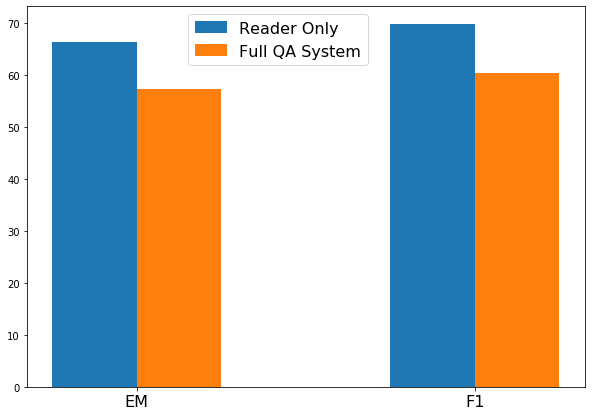

In [25]:
# hide
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import pickle

# from previous blog post
no_retriever = OrderedDict([('exact', 66.25958056093658),
             ('f1', 69.66994428499025),
             ('total', 11873),
             ('HasAns_exact', 68.91025641025641),
             ('HasAns_f1', 75.74076391627662),
             ('HasAns_total', 5928),
             ('NoAns_exact', 63.61648444070648),
             ('NoAns_f1', 63.61648444070648),
             ('NoAns_total', 5945),
             ('best_exact', 68.36519834919565),
             ('best_exact_thresh', -4.189256191253662),
             ('best_f1', 71.1144383018176),
             ('best_f1_thresh', -3.767639636993408)])

# from output of cell above
retriever = OrderedDict([('exact', 57.16331171565737),
             ('f1', 60.41835572408481),
             ('total', 11873),
             ('HasAns_exact', 50.64102564102564),
             ('HasAns_f1', 57.16044829825517),
             ('HasAns_total', 5928),
             ('NoAns_exact', 63.666947014297726),
             ('NoAns_f1', 63.666947014297726),
             ('NoAns_total', 5945),
             ('best_exact', 57.16331171565737),
             ('best_exact_thresh', 0.0),
             ('best_f1', 60.41835572408505),
             ('best_f1_thresh', 0.0)])

plt.figure(figsize=(10,7))
width = 0.25

plt.bar(np.array([1, 2]) - width/2, [no_retriever['exact'], no_retriever['f1']], width=width, label='Reader Only')
plt.bar(np.array([1, 2]) + width/2, [retriever['exact'], retriever['f1']], width=width, label='Full QA System')
plt.xticks([1,2], ['EM', 'F1'], fontsize=16)
plt.legend(loc='upper center', bbox_to_anchor=(0.45, 1), fontsize=16)

plt.savefig("qa_system_vs_reader_only.png")